In [1]:
import argparse
try:
    import torch
    torch_available = torch.cuda.is_available()
except:
    torch_available = False
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
# from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd

import matplotlib.cm as cm

cmap = cm.get_cmap('viridis')

import glob

In [2]:
import matplotlib.pyplot as plt
from utils import prepare_plt, stylize_axis, WIDTH_2COLUMNS, WIDTH_PAGE, PAD_INCHES

prepare_plt(plt, usetex=True)

In [3]:
# compute spectra using ntks

exps = [
    '../results/align_test=True,align_train=True,depth=0,diff=0.0,diff_type=random,epochs=1000,layer_align_test=True,layer_align_train=True,lr=0.003,mom=0.9,seed=100,task=cifar10_vgg19,width=0/',
    '../results/align_test=True,align_train=True,depth=0,diff=0.2,diff_type=random,epochs=1000,layer_align_test=True,layer_align_train=True,lr=0.003,mom=0.9,seed=100,task=cifar10_vgg19,width=0/',
    '../results/align_test=True,align_train=True,depth=0,diff=0.5,diff_type=random,epochs=1000,layer_align_test=True,layer_align_train=True,lr=0.003,mom=0.9,seed=100,task=cifar10_vgg19,width=0/',
    '../results/align_test=True,align_train=True,depth=0,diff=0.0,diff_type=random,epochs=1000,layer_align_test=True,layer_align_train=True,lr=0.01,mom=0.9,seed=100,task=cifar10_vgg19,width=0/',
    '../results/align_test=True,align_train=True,depth=0,diff=0.2,diff_type=random,epochs=1000,layer_align_test=True,layer_align_train=True,lr=0.01,mom=0.9,seed=100,task=cifar10_vgg19,width=0/',
    '../results/align_test=True,align_train=True,depth=0,diff=0.5,diff_type=random,epochs=1000,layer_align_test=True,layer_align_train=True,lr=0.01,mom=0.9,seed=100,task=cifar10_vgg19,width=0/',
]

all_logs = dict()

if False and torch_available:
    
    all_spectra = dict()
    for exp in exps:
        spectra = dict()
        all_logs[exp] = pd.read_pickle(exp + 'log.pkl')
        for prefix in ['train', 'test']:
            spectra[prefix] = []
            for f in sorted(glob.glob(exp + prefix + '*ntk*')):
                print(f)
                ntk = torch.load(f)
                u, s, v = torch.svd(ntk.view(1000, 1000))
                spectra[prefix].append(s.cpu().numpy())
        
            spectra[prefix] = np.array(spectra[prefix])
        all_spectra[exp] = spectra
        
    np.savez('../results/spectra.npz', all_spectra)
    zoub
else:
    for exp in exps:
        all_logs[exp] = pd.read_pickle(exp + 'log.pkl')
    all_spectra = np.load('../results/spectra.npz', allow_pickle=True)['arr_0'].item()

In [4]:
titles = ['no random labels',
          '20\\% random labels', 
          '50\\% random labels', 
          'no random labels',
          '20\\% random labels', 
          '50\\% random labels',]

files = ['vgg19-lr0003-random0-effrank.pdf',
         'vgg19-lr0003-random20-effrank.pdf',
         'vgg19-lr0003-random50-effrank.pdf',
         'vgg19-lr001-random0-effrank.pdf',
         'vgg19-lr001-random20-effrank.pdf',
         'vgg19-lr001-random50-effrank.pdf',]

findfont: Font family ['cm'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cm'] not found. Falling back to DejaVu Sans.


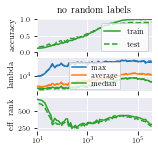

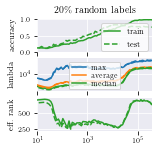

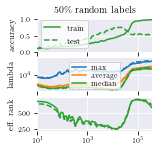

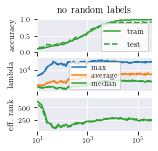

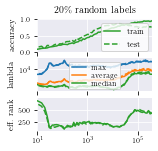

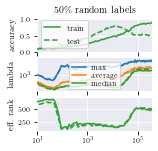

In [5]:
n = 1000

for exp, title, f_name in zip(exps, titles, files):
    
    log = all_logs[exp]
    spectra = all_spectra[exp]
    fig = plt.figure(figsize=(WIDTH_PAGE / 3 - 2 * PAD_INCHES,
                              WIDTH_PAGE / 3 - 2 * PAD_INCHES))
    
    spec = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[1, 1, 1])
    xlims = (10, log['iteration'].max())

    #### EFFECTIVE RANK

    fig.add_subplot(spec[2, 0])

    p = spectra['train'] / spectra['train'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, color='tab:green')
    
    p = spectra['test'] / spectra['test'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, linestyle='--', color='tab:green')
    
    plt.ylabel('eff. rank')
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(*xlims)
    stylize_axis(plt.gca())

    #### ACCURACIES

    fig.add_subplot(spec[0, 0])
    plt.plot(log['iteration'], log['train_acc'], label='train', color='tab:green')
    plt.plot(log['iteration'], log['test_acc'], label='test', linestyle='--', color='tab:green')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.title(title)

    plt.xscale('log')
    plt.legend()
    plt.xlim(*xlims)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)

    #### LAMBDA

    fig.add_subplot(spec[1, 0])
    plt.plot(log['iteration'], spectra['train'][:, 0], label='max', color='tab:blue')
    plt.plot(log['iteration'], np.mean(spectra['train'], axis=1), label='average', color='tab:orange')
    plt.plot(log['iteration'], np.median(spectra['train'], axis=1), label='median', color='tab:green')
    plt.plot(log['iteration'], spectra['test'][:, 0], label=None, color='tab:blue', linestyle='--')
    plt.plot(log['iteration'], np.mean(spectra['test'], axis=1), label=None, color='tab:orange', linestyle='--')
    plt.plot(log['iteration'], np.median(spectra['test'], axis=1), label=None, color='tab:green', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('lambda')
    plt.xlim(*xlims)
    plt.legend(loc='upper center', labelspacing=.2, fontsize=7)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)

    plt.savefig('spectra_rank/ranks-' + f_name, bbox_inches = "tight", pad_inches=PAD_INCHES)
    plt.show()

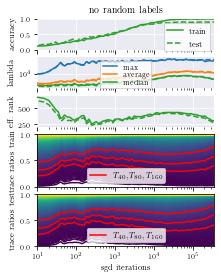

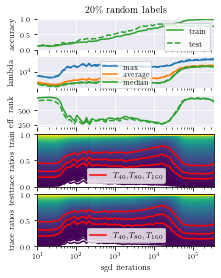

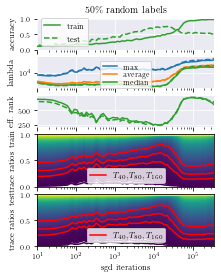

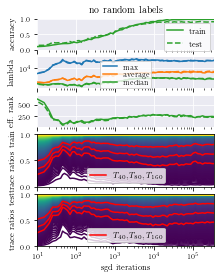

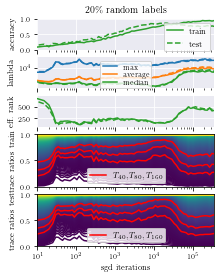

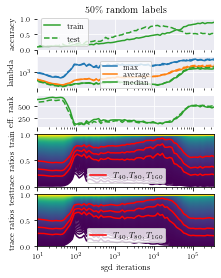

In [6]:
n = 1000

for exp, title, f_name in zip(exps, titles, files):
    
    log = all_logs[exp]
    spectra = all_spectra[exp]
    fig = plt.figure(figsize=(WIDTH_PAGE / 2 - 2 * PAD_INCHES,
                              WIDTH_PAGE / 2 * 1.3 - 2 * PAD_INCHES))
    
    spec = fig.add_gridspec(ncols=1, nrows=5, height_ratios=[1, 1, 1, 1.7, 1.7])
    xlims = (10, log['iteration'].max())

    #### EFFECTIVE RANK

    fig.add_subplot(spec[2, 0])

    p = spectra['train'] / spectra['train'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, color='tab:green')
    
    p = spectra['test'] / spectra['test'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, linestyle='--', color='tab:green')
    
    plt.ylabel('eff. rank')
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(*xlims)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)


    #### ACCURACIES

    fig.add_subplot(spec[0, 0])
    plt.plot(log['iteration'], log['train_acc'], label='train', color='tab:green')
    plt.plot(log['iteration'], log['test_acc'], label='test', linestyle='--', color='tab:green')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.title(title)

    plt.xscale('log')
    plt.legend()
    plt.xlim(*xlims)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)

    #### LAMBDA

    fig.add_subplot(spec[1, 0])
    plt.plot(log['iteration'], spectra['train'][:, 0], label='max', color='tab:blue')
    plt.plot(log['iteration'], np.mean(spectra['train'], axis=1), label='average', color='tab:orange')
    plt.plot(log['iteration'], np.median(spectra['train'], axis=1), label='median', color='tab:green')
    plt.plot(log['iteration'], spectra['test'][:, 0], label=None, color='tab:blue', linestyle='--')
    plt.plot(log['iteration'], np.mean(spectra['test'], axis=1), label=None, color='tab:orange', linestyle='--')
    plt.plot(log['iteration'], np.median(spectra['test'], axis=1), label=None, color='tab:green', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('lambda')
    plt.xlim(*xlims)
    plt.legend(loc='upper center', labelspacing=.2, fontsize=7)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    
    #### SPECTRA
    
    highlight = [40, 80, 160]

    fig.add_subplot(spec[3, 0])

    plt.xscale('log')
    cumsums = (spectra['train'].cumsum(axis=1) / spectra['train'].sum(axis=1, keepdims=True))
    for i in range(n):
        if i in highlight:
            continue
        color = cmap(float(i) / n)
        plt.plot(log['iteration'], cumsums[:, i], color=color)
    for i in highlight:
        if i == highlight[0]:
            plt.plot(log['iteration'], cumsums[:, i], color='red', label='$T_{40}, T_{80}, T_{160}$')
        else:
            plt.plot(log['iteration'], cumsums[:, i], color='red')

    plt.ylabel('trace ratios train')
    plt.legend(loc='lower center')
    plt.xlim(*xlims)
    plt.ylim(0, 1)
    plt.xlabel('sgd iterations')
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    
    fig.add_subplot(spec[4, 0])

    plt.xscale('log')
    cumsums = (spectra['test'].cumsum(axis=1) / spectra['test'].sum(axis=1, keepdims=True))
    for i in range(n):
        if i in highlight:
            continue
        color = cmap(float(i) / n)
        plt.plot(log['iteration'], cumsums[:, i], color=color)
    for i in highlight:
        if i == highlight[0]:
            plt.plot(log['iteration'], cumsums[:, i], color='red', label='$T_{40}, T_{80}, T_{160}$')
        else:
            plt.plot(log['iteration'], cumsums[:, i], color='red')

    plt.ylabel('trace ratios test')
    plt.legend(loc='lower center')
    plt.xlim(*xlims)
    plt.ylim(0, 1)
    plt.xlabel('sgd iterations')
    
    plt.savefig('spectra_rank/spectra-' + f_name, bbox_inches = "tight", pad_inches=PAD_INCHES)
    plt.show()

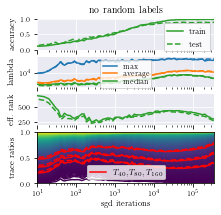

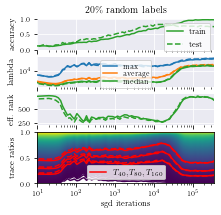

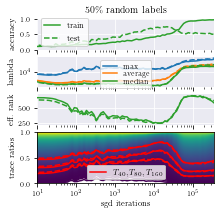

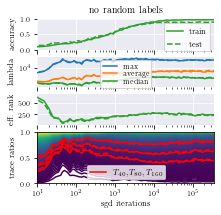

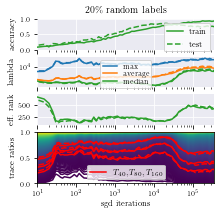

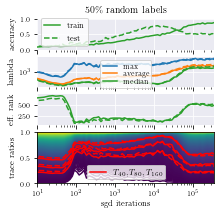

In [8]:
# 2 per row

n = 1000

for exp, title, f_name in zip(exps, titles, files):
    
    stats = dict()
    
    log = all_logs[exp]
    spectra = all_spectra[exp]
    fig = plt.figure(figsize=(WIDTH_PAGE / 2 - 2 * PAD_INCHES,
                              WIDTH_PAGE / 2 * 1.3 * 4.7 / 6.4 - 2 * PAD_INCHES))
    
    spec = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 1, 1, 1.7])
    xlims = (10, log['iteration'].max())

    #### EFFECTIVE RANK

    fig.add_subplot(spec[2, 0])

    p = spectra['train'] / spectra['train'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, color='tab:green')
    stats['eff_rank_train_min'] = np.min(spectral_entropy)
    stats['eff_rank_train_max'] = np.max(spectral_entropy)
    
    p = spectra['test'] / spectra['test'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, linestyle='--', color='tab:green')
    stats['eff_rank_test_min'] = np.min(spectral_entropy)
    stats['eff_rank_test_max'] = np.max(spectral_entropy)
    
    plt.ylabel('eff. rank')
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(*xlims)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)


    #### ACCURACIES

    fig.add_subplot(spec[0, 0])
    plt.plot(log['iteration'], log['train_acc'], label='train', color='tab:green')
    plt.plot(log['iteration'], log['test_acc'], label='test', linestyle='--', color='tab:green')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.title(title)

    plt.xscale('log')
    plt.legend()
    plt.xlim(*xlims)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)

    #### LAMBDA

    fig.add_subplot(spec[1, 0])
    plt.plot(log['iteration'], spectra['train'][:, 0], label='max', color='tab:blue')
    plt.plot(log['iteration'], np.mean(spectra['train'], axis=1), label='average', color='tab:orange')
    plt.plot(log['iteration'], np.median(spectra['train'], axis=1), label='median', color='tab:green')
    plt.plot(log['iteration'], spectra['test'][:, 0], label=None, color='tab:blue', linestyle='--')
    plt.plot(log['iteration'], np.mean(spectra['test'], axis=1), label=None, color='tab:orange', linestyle='--')
    plt.plot(log['iteration'], np.median(spectra['test'], axis=1), label=None, color='tab:green', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('lambda')
    plt.xlim(*xlims)
    plt.legend(loc='upper center', labelspacing=.2, fontsize=7)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    
    #### SPECTRA
    
    highlight = [40, 80, 160]

    fig.add_subplot(spec[3, 0])

    plt.xscale('log')
    cumsums = (spectra['train'].cumsum(axis=1) / spectra['train'].sum(axis=1, keepdims=True))
    for i in range(n):
        if i in highlight:
            continue
        color = cmap(float(i) / n)
        plt.plot(log['iteration'], cumsums[:, i], color=color)
    for i in highlight:
        if i == highlight[0]:
            plt.plot(log['iteration'], cumsums[:, i], color='red', label='$T_{40}, T_{80}, T_{160}$')
        else:
            plt.plot(log['iteration'], cumsums[:, i], color='red')

    plt.ylabel('trace ratios')
    plt.legend(loc='lower center')
    plt.xlim(*xlims)
    plt.ylim(0, 1)
#     plt.setp(plt.gca().get_xticklabels(), visible=False)
    
    cumsums = (spectra['test'].cumsum(axis=1) / spectra['test'].sum(axis=1, keepdims=True))
    for i in highlight:
        plt.plot(log['iteration'], cumsums[:, i], color='red', linestyle='--')

    plt.legend(loc='lower center')
    plt.xlim(*xlims)
    plt.ylim(0, 1)
    plt.xlabel('sgd iterations')
    
    plt.savefig('spectra_rank/spectra1-' + f_name, bbox_inches = "tight", pad_inches=PAD_INCHES)
    plt.show()
    
    with open('spectra_rank/spectra1-' + f_name[:-4] + '.txt', 'w') as f:
        f.write(str(stats))

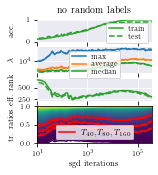

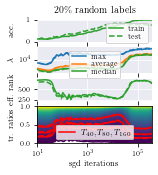

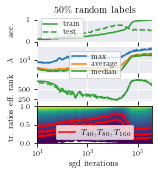

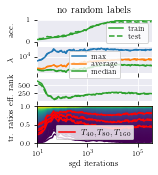

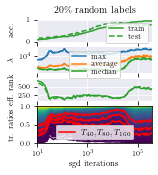

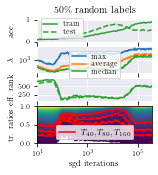

In [15]:
# 3 per row

n = 1000

for exp, title, f_name in zip(exps, titles, files):
    
    axes = []
    stats = dict()
    
    log = all_logs[exp]
    spectra = all_spectra[exp]
    fig = plt.figure(figsize=(WIDTH_PAGE / 3 - 2 * PAD_INCHES,
                              WIDTH_PAGE / 3 * 1.5 * 4.7 / 6.4 - 2 * PAD_INCHES))
    
    spec = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 1.2, 1, 1.7])
    xlims = (10, log['iteration'].max())

    #### EFFECTIVE RANK

    axes.append(fig.add_subplot(spec[2, 0]))

    p = spectra['train'] / spectra['train'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, color='tab:green')
    stats['eff_rank_train_min'] = np.min(spectral_entropy)
    stats['eff_rank_train_max'] = np.max(spectral_entropy)
    
    p = spectra['test'] / spectra['test'].sum(axis=1, keepdims=True)
    spectral_entropy = np.exp(-(p * np.log(p)).sum(axis=1))
    plt.plot(log['iteration'], spectral_entropy, linestyle='--', color='tab:green')
    stats['eff_rank_test_min'] = np.min(spectral_entropy)
    stats['eff_rank_test_max'] = np.max(spectral_entropy)
    
    plt.ylabel('eff. rank')
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlim(*xlims)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)


    #### ACCURACIES

    axes.append(fig.add_subplot(spec[0, 0]))
    
    plt.plot(log['iteration'], log['train_acc'], label='train', color='tab:green')
    plt.plot(log['iteration'], log['test_acc'], label='test', linestyle='--', color='tab:green')
    plt.ylabel('acc.')
    plt.ylim(0, 1)
    plt.title(title)

    plt.xscale('log')
    plt.legend(labelspacing=.2, fontsize=7)
    plt.xlim(*xlims)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)

    #### LAMBDA

    axes.append(fig.add_subplot(spec[1, 0]))
    
    plt.plot(log['iteration'], spectra['train'][:, 0], label='max', color='tab:blue')
    plt.plot(log['iteration'], np.mean(spectra['train'], axis=1), label='average', color='tab:orange')
    plt.plot(log['iteration'], np.median(spectra['train'], axis=1), label='median', color='tab:green')
    plt.plot(log['iteration'], spectra['test'][:, 0], label=None, color='tab:blue', linestyle='--')
    plt.plot(log['iteration'], np.mean(spectra['test'], axis=1), label=None, color='tab:orange', linestyle='--')
    plt.plot(log['iteration'], np.median(spectra['test'], axis=1), label=None, color='tab:green', linestyle='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('$\lambda$')
    plt.xlim(*xlims)
    plt.legend(loc='upper center', labelspacing=.2, fontsize=7)
    stylize_axis(plt.gca())
    plt.setp(plt.gca().get_xticklabels(), visible=False)
    
    #### SPECTRA
    
    highlight = [40, 80, 160]

    axes.append(fig.add_subplot(spec[3, 0]))

    plt.xscale('log')
    cumsums = (spectra['train'].cumsum(axis=1) / spectra['train'].sum(axis=1, keepdims=True))
    for i in range(n):
        if i in highlight:
            continue
        color = cmap(float(i) / n)
        plt.plot(log['iteration'], cumsums[:, i], color=color)
    for i in highlight:
        if i == highlight[0]:
            plt.plot(log['iteration'], cumsums[:, i], color='red', label='$T_{40}, T_{80}, T_{160}$')
        else:
            plt.plot(log['iteration'], cumsums[:, i], color='red')

    plt.ylabel('tr. ratios')
    plt.legend(loc='lower center')
    plt.xlim(*xlims)
    plt.ylim(0, 1)
#     plt.setp(plt.gca().get_xticklabels(), visible=False)
    
    cumsums = (spectra['test'].cumsum(axis=1) / spectra['test'].sum(axis=1, keepdims=True))
    for i in highlight:
        plt.plot(log['iteration'], cumsums[:, i], color='red', linestyle='--')

    plt.legend(loc='lower center')
    plt.xlim(*xlims)
    plt.ylim(0, 1)
    plt.xlabel('sgd iterations')
    
    plt.gcf().align_ylabels(axes)
    
    plt.savefig('spectra_rank/spectra1-' + f_name, bbox_inches = "tight", pad_inches=PAD_INCHES)
    plt.show()
    
    with open('spectra_rank/spectra1-' + f_name[:-4] + '.txt', 'w') as f:
        f.write(str(stats))